---
title: Statistical Learning Final Project
author: Andrew Dean
date: '2025-05-12'
image: "beat.gif"
description: "Predicts a Song's Genre From Its Lyrics"
code-fold: true
execute:
    warning: false
    message: false
---

## Can we predict a song’s genre solely from its lyrics?
This question explores whether the words and phrasing artists choose carry strong enough genre‐specific signals — beyond melody or instrumentation — to allow an automated classifier to recover “pop,” “rock,” “jazz,” etc., purely from the lyric text. This is a classic supervised task where each example (lyrics) is paired with a known label (its genre). Once trained, a model can tag new or unlabeled songs, possibly helping streaming services or recommendation engines organize catalogs.

I’ll use the TCC–CEDS music dataset (1950–2019), which provides for each track: lyrics text along with metadata features like danceability, loudness, acousticness, valence, sadness etc. But, in this project I ignore all metadata and rely solely on the lyrics column. This gives us ~4,000 songs across 7 genres, with enough samples per class to train and validate my model, a neural classifier.

[Access the Data.](https://www.kaggle.com/datasets/saurabhshahane/music-dataset-1950-to-2019?resource=download)

In [20]:
library(torch)
library(text2vec)
library(tidyverse)
library(rsample)
library(coro)
set.seed(1)


Attaching package: ‘text2vec’


The following objects are masked from ‘package:keras’:

    fit, normalize



Attaching package: ‘coro’


The following object is masked from ‘package:dplyr’:

    collect




In [21]:
music <- read.csv("tcc_ceds_music.csv")

Here are some of the features from the data:

- artist_name	
- track_name	
- release_date	
- genre	
- lyrics	
- len	
- dating	
- violence	
- world.life
- feelings	
- danceability	
- loudness	
- acousticness	
- instrumentalness	
- valence	
- energy	
- topic	
- age	
- genre_id

This dataset has a lot of interesting features. But, the one that is most relevant to my research question is the track's lyrics. I want to predict the genre of a track solely based on that! To do that, I'll build a neural network.

## Basic Model Background. How does it work?
I teach the model to “read” each song’s lyrics much like you might skim a paragraph: first, I turn every word into a simple number and make every song the same length by cutting off extra words or padding with blanks. Next, the model looks up each number in a tiny “dictionary” of meaning — so words that often appear in rock songs, say, end up with similar little summaries, and words from jazz songs get a different summary. To keep it honest, I occasionally (about one in five words) pretend a word isn’t there, so the model can’t just memorize one or two tell-tale words. After that, it takes all those word summaries and averages them into a single, very short summary of the whole song. That summary then goes into a small decision step that spits out a score for each genre (“pop,” “country,” etc.). During training, the model sees whether its guess was right or wrong and adjusts those word summaries and decision rules to get closer to the correct genres. By repeating this on small batches of songs over several passes, it gradually learns which lyrical patterns go with which genre — all without any rules beyond “here are the words, and here is the true genre.”

To help understand on a deeper level, I'll explain each code chunk to get more insight into how a neural network actually functions. But feel free to **skip to the "Results"** section which more broadly explains what we accomplished in non-technical terms.

## Building the Model

This first chunk first creates a genre_map that assigns each of our seven target genres a unique integer from 0 to 6. I then filter the data frame to keep only songs whose genre matches one of these names, dropping any others. Finally, I use mutate to look up each song’s genre string in the genre_map and create a new column, genre_id, holding the corresponding integer label. Converting textual genres into numeric IDs is essential because the neural network and its loss function require numeric class labels rather than strings.

In [22]:
genre_map <- c(pop=0, country=1, blues=2, jazz=3, reggae=4, rock=5, `hip hop`=6)
music <- music %>%
  filter(genre %in% names(genre_map)) %>%
  mutate(genre_id = genre_map[genre])

In [41]:
library(dplyr)
music %>%
  count(genre) %>%
  mutate(prop = n / nrow(music))

genre,n,prop
<chr>,<int>,<dbl>
blues,4604,0.16227266
country,5445,0.19191456
hip hop,904,0.03186240
jazz,3845,0.13552094
pop,7042,0.24820245
reggae,2498,0.08804455
rock,4034,0.14218243


If we were to always predict the pop genre, we'd get 24.8% accuracy. So that's the number to beat! Let's see what we can do.

In [23]:
splits <- initial_split(music, prop = 0.8, strata = "genre_id")
train_music <- training(splits)
val_music <- testing(splits)

Here, I build the word vocabulary that the model will use to turn lyrics into numbers. First, I set min_freq <- 50 to ignore any word that appears fewer than fifty times across all training lyrics. I then take each song’s lyrics, convert them to lowercase, and apply word_tokenizer to split them into lists of tokens. Passing those token lists into itoken() gives us an iterator that create_vocabulary() uses to count every unique word. By piping into prune_vocabulary(term_count_min = min_freq), I drop all low-frequency tokens, leaving only words with enough examples to learn reliable embeddings. Finally, I pull out the surviving terms into terms, record how many there are in vocab_size, and build term_index - a named integer vector that maps each word to its position in the vocabulary. This mapping is what I use later to convert words into integer IDs for the neural network.

In [ ]:
min_freq <- 50
tokens <- train_music$lyrics %>% tolower() %>% word_tokenizer
it <- itoken(tokens)
vocab <- create_vocabulary(it) %>% prune_vocabulary(term_count_min = min_freq)
terms <- vocab$term
vocab_size <- length(terms)
term_index <- seq_along(terms); names(term_index) <- terms

In [26]:
max_len <- 150
unk_index <- vocab_size + 1

text_to_tensor <- function(txt) {
  toks <- word_tokenizer(tolower(txt))[[1]]
  idxs <- term_index[toks]
  idxs <- idxs[!is.na(idxs)]
  # truncate or pad!
  if (length(idxs) > max_len) idxs <- idxs[1:max_len]
  if (length(idxs) < max_len) idxs <- c(idxs, rep(unk_index, max_len - length(idxs)))
  torch_tensor(idxs, dtype = torch_long())
}

This next block converts all of the raw lyrics and genre labels into the torch‐ready tensors and bundles them for training and validation.

In [33]:
train_tensors <- map(train_music$lyrics, text_to_tensor)
train_labels <- torch_tensor(train_music$genre_id + 1, dtype = torch_long())
val_tensors <- map(val_music$lyrics, text_to_tensor)
val_labels <- torch_tensor(val_music$genre_id + 1, dtype = torch_long())

Next I define a custom `LyricsDataset` class. This is essentially a wrapper around the precomputed tensors so that the torch dataloader can iterate over them. In `initialize`, I store the list of text tensors and the label tensor on the dataset object. The `.getitem` method tells torch how to fetch the i-th example: it returns a named list with `x` as the 150-length lyric tensor and `y` as the corresponding genre label. Finally, `.length` reports how many examples are in the dataset (i.e. the length of the label vector). With this in place, I can hand `LyricsDataset` to `dataloader()` and it will automatically batch and shuffle the data during training.

In [34]:
LyricsDataset <- dataset(
  initialize = function(texts, labels) {
    self$texts <- texts
    self$labels <- labels
  },
  .getitem = function(i) {
    list(x = self$texts[[i]], y = self$labels[i])
  },
  .length = function() length(self$labels)
)

In [35]:
train_ds <- LyricsDataset(train_tensors, train_labels)
val_ds <- LyricsDataset(val_tensors,   val_labels)

train_dl <- dataloader(train_ds, batch_size = 8, shuffle = TRUE)
val_dl <- dataloader(val_ds,   batch_size = 8)

Below I define the model. It has three layers: an embedding layer that maps each word index into a learned vector of size `embed_dim`; a dropout layer (with probability `dropout_p`) that zeroes out a fraction of those embeddings to regularize; and a fully connected (`nn_linear`) layer that projects the averaged embedding into `num_classes` logits. In the `forward` pass, the input `x` (of shape `[batch, max_len]`) is looked up in the embedding table to produce a `[batch, max_len, embed_dim]` tensor, dropped out, then averaged over the sequence dimension (collapsing to `[batch, embed_dim]`). That pooled vector is passed through the linear layer to get `[batch, num_classes]` scores, and I apply dropout once more before returning the raw logits.

In [36]:
model <- nn_module(
  initialize = function(vocab_size, embed_dim, num_classes, dropout_p) {
    self$embed <- nn_embedding(vocab_size + 1, embed_dim)
    self$drop <- nn_dropout(dropout_p)
    self$fc <- nn_linear(embed_dim, num_classes)
  },
  forward = function(x) {
    e <- self$embed(x)
    e <- self$drop(e)
    avg <- torch_mean(e, dim = 2)
    out <- self$fc(avg)
    self$drop(out)
  }
)

# ChatGPT helped me clarify what I needed for this model and helped me build it.

Here I choose our key hyperparameters - an embedding size of 3, seven output classes, and a 20 % dropout rate - and use them to instantiate the model. I then use the Adam optimizer (learning rate 0.1) to update all of the network’s parameters during training, and define our loss function as cross‐entropy, which compares the raw output logits against the true class labels. Together, `optimizer` and `loss_fn` set up everything the training loop needs to compute gradients and perform parameter updates.

In [37]:
embed_dim <- 3
num_classes<- 7
dropout_p <- 0.2

net <- model(vocab_size, embed_dim, num_classes, dropout_p)
optimizer <- optim_adam(net$parameters, lr = 0.1)
loss_fn <- nn_cross_entropy_loss()

In the training loop (below), I iterate over a 10 epochs. I then initialize counters for cumulative loss, correct predictions, and total examples. Inside the `coro::loop`, each batch `b` from `train_dl` is unpacked into `b$x` (the lyric tensors) and `b$y` (the shifted labels), and I zero out any previous gradients before computing `out <- net(b$x)` (this is a crucial step!). The loss is then calculated via `loss_fn(out, b$y)`, back-propagated with `loss$backward()`, and the optimizer steps to update the weights. After each batch, I accumulate the scalar loss, infer the predicted class by taking `argmax` over the logits, and tally how many predictions match the true labels. Once all batches have run, I report the average loss per batch and the overall training accuracy for that epoch. This loop drives the model’s gradual improvement by repeatedly adjusting its parameters to minimize cross‐entropy loss on the training data (the basis of a general neural net).

In [ ]:
num_epochs <- 10
for (epoch in 1:num_epochs) {
  net$train()
  total_loss <- 0
  total_correct <- 0
  total_examples <- 0

  coro::loop(for (b in train_dl) {
    optimizer$zero_grad()
    out <- net(b$x)
    loss <- loss_fn(out, b$y)
    loss$backward()
    optimizer$step()

    total_loss <- total_loss + loss$item()
    preds <- out$argmax(dim = 2)
    total_correct <- total_correct + (preds == b$y)$sum()$item()
    total_examples <- total_examples + b$y$size(1)
  })

  cat(sprintf(
    "Epoch %2d | loss = %.4f | acc = %.3f\n",
    epoch, total_loss / length(train_dl), total_correct / total_examples
  ))
}

Epoch  1 | loss = 1.8268 | acc = 0.252
Epoch  2 | loss = 1.7578 | acc = 0.290
Epoch  3 | loss = 1.7141 | acc = 0.318
Epoch  4 | loss = 1.6960 | acc = 0.328
Epoch  5 | loss = 1.6885 | acc = 0.332
Epoch  6 | loss = 1.6849 | acc = 0.336
Epoch  7 | loss = 1.6775 | acc = 0.340
Epoch  8 | loss = 1.6717 | acc = 0.345
Epoch  9 | loss = 1.6724 | acc = 0.343
Epoch 10 | loss = 1.6709 | acc = 0.344


Next is the evaluation phase. I switch the network into inference mode with `net$eval()`, which turns off dropout and other training‐only behaviors. I then initialize counters for the number of correct predictions and total examples. As I loop over batches from `val_dl`, I feed each batch’s inputs `b$x` through the model to get raw scores, take the `argmax` across the class dimension to obtain predicted labels, and compare these to the true labels `b$y`. I accumulate the count of matches and the total number of examples. Finally, I divide `val_correct` by `val_total` to compute and print the overall validation accuracy - the key measure of how well the model generalizes to unseen data.

In [ ]:
net$eval()
val_correct <- 0
val_total <- 0

coro::loop(for (b in val_dl) {
  out <- net(b$x)
  preds <- out$argmax(dim = 2)
  val_correct <- val_correct + (preds == b$y)$sum()$item()
  val_total <- val_total   + b$y$size(1)
})

cat(sprintf("Validation accuracy: %.3f\n", val_correct / val_total))

Validation accuracy: 0.291


We get a validation accuracy of 29.1%, which is better than just always guessing the 'pop' genre.

# Assisting our NN with A Random Forest

Next I'll use a classic method that we've used in class to extend the work I've already done above to help me more comprehensively answer my research question. I'll use a random forest to show which words most strongly influence predictions, giving us insights into genre-specific vocabulary. Also this model will act as a comparison to our NN.

In [45]:
library(text2vec)
library(ranger)
library(ggplot2)

I used TF–IDF - a text-version of PCA - to weight words by how uncommon they are across all songs, so that rare but telling terms get more emphasis. In class, we used PCA to simplify our numeric data and ensemble methods on our custom features to improve accuracy and make the results easier to understand; TF–IDF applies the same idea to lyrics. Raw word counts include thousands of tokens - many (“the,” “and,” etc.) add noise - so TF–IDF down-weights those and amplifies genre-specific words. This not only raises our Random Forest’s accuracy but also yields clear importance scores, showing exactly which words drive its genre predictions. Unlike our tidytext counts, TF–IDF corrects for overly common terms, making sure the model focuses on truly telling vocabulary.

In [46]:
# vectorize lyrics with TF-IDF
it_train <- itoken(train_music$lyrics,
                   preprocessor = tolower,
                   tokenizer    = word_tokenizer,
                   progressbar  = FALSE)
vocab <- create_vocabulary(it_train) %>% prune_vocabulary(term_count_min = 50)
vectorizer <- vocab_vectorizer(vocab)
dtm_train <- create_dtm(it_train, vectorizer)
tfidf <- TfIdf$new()
dtm_train_tfidf <- fit_transform(dtm_train, tfidf)

it_val <- itoken(val_music$lyrics,
                 preprocessor = tolower,
                 tokenizer    = word_tokenizer,
                 rogressbar  = FALSE)

dtm_val <- create_dtm(it_val, vectorizer)
dtm_val_tfidf <- transform(dtm_val, tfidf)

In [49]:
train_rf <- as.data.frame(as.matrix(dtm_train_tfidf))
train_rf$genre <- factor(train_music$genre)
val_rf <- as.data.frame(as.matrix(dtm_val_tfidf))
val_rf$genre <- factor(val_music$genre)

colnames(train_rf) <- make.names(colnames(train_rf))
colnames(val_rf) <- make.names(colnames(val_rf))

In [ ]:
# the model!
rf_mod <- ranger(genre ~ ., data = train_rf, importance = "impurity")
print(rf_mod)

Growing trees.. Progress: 17%. Estimated remaining time: 2 minutes, 35 seconds.
Growing trees.. Progress: 34%. Estimated remaining time: 2 minutes, 2 seconds.
Growing trees.. Progress: 50%. Estimated remaining time: 1 minute, 31 seconds.
Growing trees.. Progress: 67%. Estimated remaining time: 1 minute, 0 seconds.
Growing trees.. Progress: 84%. Estimated remaining time: 29 seconds.
Growing trees.. Progress: 100%. Estimated remaining time: 0 seconds.
Ranger result

Call:
 ranger(genre ~ ., data = train_rf, importance = "impurity") 

Type:                             Classification 
Number of trees:                  500 
Sample size:                      22696 
Number of independent variables:  2898 
Mtry:                             53 
Target node size:                 1 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error:             61.45 % 


Validation accuracy: 0.3985201 


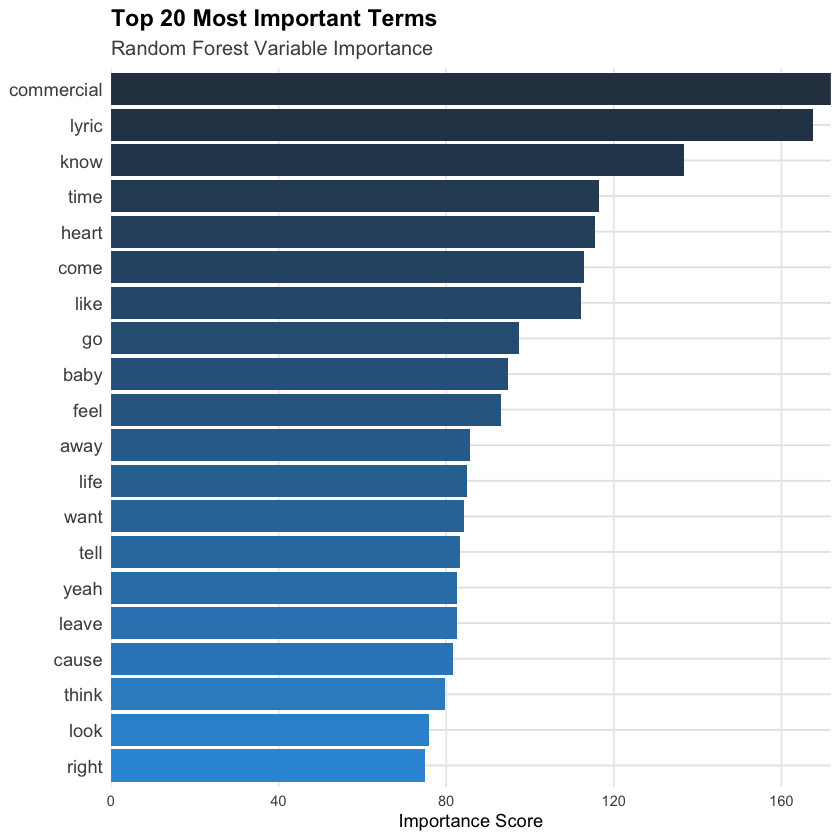

In [ ]:
# plot top-20 important terms
imp <- sort(rf_mod$variable.importance, decreasing = TRUE)[1:20]
imp_df <- data.frame(term = names(imp), importance = imp)

colors <- colorRampPalette(c("#2C3E50", "#3498DB"))(20)

ggplot(imp_df, aes(importance, reorder(term, importance))) +
  geom_col(fill = colors) +
  labs(
    title = "Top 20 Most Important Terms",
    subtitle = "Random Forest Variable Importance",
    x = "Importance Score",
    y = NULL
  ) +
  theme_minimal() +
  theme(
    panel.grid.major.y = element_line(color = "gray90"),
    panel.grid.minor = element_blank(),
    axis.text.y = element_text(size = 11),
    plot.title = element_text(face = "bold", size = 14),
    plot.subtitle = element_text(color = "gray30", size = 12)
  ) +
  scale_x_continuous(expand = c(0, 0))

# look at validation accuracy
preds <- predict(rf_mod, data = val_rf)$predictions
cat("Validation accuracy:", mean(preds == val_rf$genre), "\n")

The random forest achieved 39.9% accuracy on the validation set. This is a big improvement over the naive baseline (always predicting the most common genre,24.8%), indicating that the TF-IDF representations capture meaningful genre signals in the lyrics. The close match between OOB and validation accuracies also suggests the model generalizes consistently without overfitting. By contrast, my neural network reached only 29.1% validation accuracy, pretty far below the forest’s 39.9%. The RF’s strength here likely comes from its direct use of thousands of term-level TF-IDF features, which help to exploit word frequency patterns. The neural net, with just a 3-dimensional embedding and simple averaging, may under represent the important vocabulary distinctions needed to catch genre differences. Also, the forest gives explicit feature importances, showing which words drive its predictions which is great to see. The neural network approach, on the other hand, could maybe benefit from larger embeddings or a more complex architecture to increase its performance.

## Results

Our Random Forest model - think of it as a team of many simple decision trees voting on genre - was able to correctly guess a song’s genre about 40% of the time on new data. That’s a big jump from the 25% you’d get by always picking the single most common genre, and it tells us that the way we weighed words really does highlight the right lyrical clues. Because its out-of-bag accuracy was nearly the same as the 40% we saw on held-out songs, we know it isn’t just memorizing the training set — it’s learning patterns that hold up on fresh examples.

By comparison, the neural network, which boiled each song down to a three-number summary, only got about 29% correct on the same test set. The Forest’s edge likely comes from having thousands of individual word level signals to draw on, whereas the simple neural setup may miss some of the subtle vocabulary that really marks a genre. One extra benefit of the Forest is that it tells us which specific words matter most—terms like “commercial,” “lyric,” or “know” popped up as surprisingly influential, even if they don’t jump out as obvious genre markers.

This project set out to answer a pretty simple question: **can you tell a song’s genre just by reading its lyrics?** To find out, I trained two different “readers” of lyrics. The first was a neural network that translates each word into a handful of numbers and then makes a guess, and the second was a Random Forest that looks at how often each word appears (after giving rare, telling words extra weight). In testing, the Forest correctly identified genre nearly **40%** of the time, well above the roughly **25%** you’d get by always picking the most common genre, and its internal importance scores showed which words mattered most. The neural network got **29%** accuracy with its simple three-number summary of each song. In the end, both methods beat the naïve baseline, but the Random Forest proved both more accurate and more transparent, highlighting the key lyrical clues that help distinguish genres.

# Sources
Here are some websites I used to help guide me through the neural net model building. Note that I have also taken Machine Learning, which came in handy when doing this project!

[Torch](https://torch.mlverse.org/technical/tensors/)

[Torch in R](https://blogs.rstudio.com/ai/posts/2020-09-29-introducing-torch-for-r/)

[Neural net intro](https://www.youtube.com/watch?v=aircAruvnKk)

[ChatGPT](https://chatgpt.com)

ChatGPT provided general coding help and an inuitive sense when building the neural network.